# T1w Classifier
This notebook is used for fast check the MRIClassifier results, mostly for the part of interpretability.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

from src.models.data_labeler import LabelClinicalData
from src.models.utils.balancers import RandomDownsampler

from src.models.data_splitter import HoldoutSplitter
from src.models.data_loader import MROasis3Datamodule
from src.models.mri_classifier import MRIClassifier

from captum.attr import IntegratedGradients

RANDOM_SEED = 1704

Set up the variables for training, if the GPU is available it will be used along with 16bit precision, otherwise will train on the CPU with 32bit precision

In [2]:
if torch.cuda.is_available():
    accelerator = 'gpu'
    precision=16
    avail_gpu = torch.cuda.device_count()
    print("Available GPUs", avail_gpu)
    print("GPUs model names")
    for i in range(avail_gpu):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    cpu_count = multiprocessing.cpu_count()
else:
    accelerator = 'cpu'
    precision=32
    print("No available GPU")
    cpu_count = 1
print(f"CPU available cores: {multiprocessing.cpu_count()}")
print(f"Trainer will use {precision} bit floating point precision")
print(f"Dataloader will use {cpu_count} workers")
print(f"Seeding everithing with: {pl.seed_everything(RANDOM_SEED, workers=True)}")

Global seed set to 1704


No available GPU
CPU available cores: 8
Trainer will use 32 bit floating point precision
Dataloader will use 1 workers
Seeding everithing with: 1704


In [3]:
clinical_mr = pd.read_csv("../data/processed/clinical-mr-full.csv")
labeler = LabelClinicalData("../data/raw/clinical-map.json")
index = pd.read_csv("../data/processed/data/index.csv")

print(f"Index lenght: {len(index)}")
clinical_mr = labeler(clinical_mr)
print("Merging")
index = pd.merge(pd.read_csv("../data/processed/data/index.csv"), clinical_mr[['MR_ID',"Label"]], on="MR_ID", how='left')
print(f"Merged lenght: {len(index)}")
index.head()

Index lenght: 2092
Merging
Merged lenght: 2092


,ADRC_ADRCCLINICALDATA_ID,Subject,MR_ID,ageAtEntry,Age,DaysAfterEntry_clinic,DaysAfterEntry_mr,DaysDistance,Scanner,T1w,...,memory,orient,perscare,sumbox,apoe,height,weight,min_value,max_value,Label
0,OAS30001_ClinicalData_d0000,OAS30001,OAS30001_MR_d0129,65.149895,65.0,0,129.0,129.0,3.0T,2.0,...,0.0,0.0,0.0,0.0,23.0,NaN,NaN,0.0,568.0,False
1,OAS30001_ClinicalData_d0722,OAS30001,OAS30001_MR_d0757,65.149895,67.0,722,757.0,35.0,3.0T,2.0,...,0.0,0.0,0.0,0.0,23.0,64.0,162.0,0.0,624.0,False
2,OAS30001_ClinicalData_d2181,OAS30001,OAS30001_MR_d2430,65.149895,71.0,2181,2430.0,249.0,3.0T,1.0,...,0.0,0.0,0.0,0.0,23.0,63.0,180.0,-24.0,719.0,False
3,OAS30001_ClinicalData_d3025,OAS30001,OAS30001_MR_d3132,65.149895,73.0,3025,3132.0,107.0,3.0T,1.0,...,0.0,0.0,0.0,0.0,23.0,64.0,180.0,0.0,514.0,False
4,OAS30001_ClinicalData_d3675,OAS30001,OAS30001_MR_d3746,65.149895,NaN,3675,3746.0,71.0,NaN,1.0,...,0.0,0.0,0.0,0.0,23.0,64.0,192.0,-18.0,614.0,False


For this notebook we will use the simple Randomdownsampler in order to reduce the amount of samples in the majority class

In [4]:
sampler = RandomDownsampler(index, random_state=RANDOM_SEED)
clinical_mr = sampler.get_sample()
clinical_mr.groupby("Label").count().MR_ID

Label
False    343
True     343
Name: MR_ID, dtype: int64

For splitting the data we rely on the Holdout splitter with default parameters 80/20 train/test

In [5]:
splitter = HoldoutSplitter(clinical_mr)
data_folder = "../data/processed/data/"

We now start training the model

In [6]:
torch.cuda.empty_cache()

lr =5e-5
decay=0.96
batch_size=1
workers=cpu_count
precision=precision
model = MRIClassifier(lr, decay, batch_size)
data_module = MROasis3Datamodule(data_folder, splitter, batch_size=batch_size, num_workers=cpu_count)

trainer = pl.Trainer(accelerator=accelerator, precision=precision, devices=1, max_epochs=1, accumulate_grad_batches=8)

trainer.fit(model, datamodule=data_module)

C:\Users\zatoi\anaconda3\envs\3dConvAD\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | train_metrics | MetricCollection  | 0     
1 | val_metrics   | MetricCollection  | 0     
2 | test_metrics  | MetricCollection  | 0     
3 | conv1         | Sequential        | 1.8 K 
4 | conv2         | Sequential        | 110 K 
5 | conv3         | Sequential        | 221 K 
6 | conv4         | Sequential        | 884 K 
7 | dense         | Sequential        | 4.7 M 
8 | classifier    | Sigmoid           | 0     
9 | criterion     | BCEWithLogitsLoss | 0     
------------------

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\zatoi\anaconda3\envs\3dConvAD\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\zatoi\anaconda3\envs\3dConvAD\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
C:\Users\zatoi\anaconda3\envs\3dConvAD\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this mach

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## Integrated gradients
We check how integrated gradients works, at first step we create a new dataset type which load a single MR scan with no label and pass it into a Dataloader.

In [7]:
class T1wDataset(Dataset):
    def __init__(self, paths):
        if paths is str:
            self.paths = [paths]
        self.paths = paths

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx):
        x = torch.FloatTensor(np.expand_dims(np.load(self.paths[idx], allow_pickle=True)["x"], axis=0))
        return x

ds = T1wDataset(["../data/processed/data/OAS30001_MR_d3132.npz"])
data_loader = DataLoader(ds)

In [16]:
batch = next(iter(data_loader))
ig = IntegratedGradients(model.forward)
x = batch
attr = ig.attribute(x, n_steps=15)

print(f"Attribute shape:{attr.shape}")

Attribute shape:torch.Size([1, 1, 128, 128, 60])


Now we plots the Integrated gradient overlapped to the brain

(-0.5, 127.5, 127.5, -0.5)

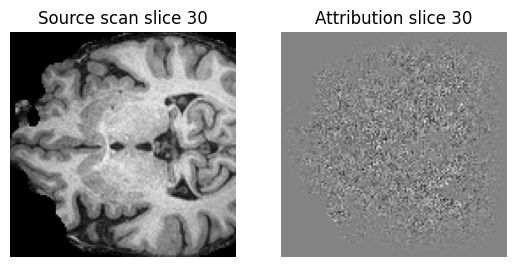

In [22]:
img, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(x[0,0,:,:,30],cmap='gray')
ax2.imshow(attr[0,0,:,:,30], cmap='gray',)

ax1.set_title("Source scan slice 30")
ax2.set_title("Attribution slice 30")
ax1.axis('off')
ax2.axis('off')

## Conclusions
In this notebook we have seen how to train the model and how to use the Integrated Gradients technique to add a form of interpretability to the model